In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sys

from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
data = pd.read_csv('ESS82016.csv')

In [5]:
print('Data set information:')
data.info()
# Columns: 534 - represents variables corresponding to questions
# Rows: 44387 - represents respondents

Data set information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44387 entries, 0 to 44386
Columns: 534 entries, name to pweight
dtypes: float64(226), int64(298), object(10)
memory usage: 180.8+ MB


In [6]:
all_variables = pd.read_csv('variables.csv')

In [7]:
all_variables
# There we have variables with their names and a short version of the question as a label, data type, etc.

,Name,Label,Country_specific,Scale_type,Type,Format,Valid,Invalid,Question,Group
0,cntry,Country,no,nominal,discrete,character-2,44387,0,5 Country,Group Country
1,dweight,Design weight,no,continuous,continuous,numeric-4.2,44387,0,R17 Design weight,Group Weights
2,pspwght,Post-stratification weight including design we...,no,continuous,continuous,numeric-4.2,44387,0,R18 Post-stratification weight including desig...,Group Weights
3,pweight,Population size weight (must be combined with ...,no,continuous,continuous,numeric-8.2,44387,0,R19 Population size weight (must be combined w...,Group Weights
4,nwspol,"News about politics and current affairs, watch...",no,continuous,continuous,numeric-4.0,43863,524,"A1 On a typical day, about how much time do yo...",Group Media and social trust
...,...,...,...,...,...,...,...,...,...,...
529,inwmme,"End of interview, month",no,continuous,continuous,numeric-2.0,44378,9,"R8 End of interview, month",Group Administrative variables
530,inwyye,"End of interview, year",no,continuous,continuous,numeric-4.0,44378,9,"R9 End of interview, year",Group Administrative variables
531,inwehh,"End of interview, hour",no,continuous,continuous,numeric-2.0,43976,411,"R10 End of interview, hour",Group Administrative variables
532,inwemm,"End of interview, minute",no,continuous,continuous,numeric-2.0,43977,410,"R11 End of interview, minute",Group Administrative variables


In [8]:
all_variables['Group'].unique()

array(['Group Country', 'Group Weights', 'Group Media and social trust',
       'Group Politics',
       'Group Subjective well-being, social exclusion, religion, national and ethnic identity',
       'Group Climate change', 'Group Welfare attitudes',
       'Group Gender, Year of birth and Household grid',
       'Group Socio-demographics', 'Group Human values',
       'Group Administrative variables'], dtype=object)

In [9]:
all_variables['Scale_type'].unique()

array(['nominal', 'continuous', 'ordinal', 'binary'], dtype=object)

In [10]:
# Cleaning data by deleting unnecessary Groups and specific data types:
# Keeping only Country not specific, ordinal data. 
# excluding "Group Administrative variables","Group Administrative variables", "Group Welfare attitudes", "Group Socio-demographics" and "Group Human values" data. 

not_country_specific_variables = all_variables.query('Country_specific == "no" and Scale_type == "ordinal" and Group != "Group Administrative variables" and Group != "Group Welfare attitudes" and Group != "Group Socio-demographics" and Group != "Group Human values"')

# Adding nominal variables: "Country", "Gender":
nominal_variables = all_variables.query('Name in ["cntry", "gndr"]')

# Adding continuous variables: "Age","Years of full-time education completed","News about politics and current affairs, watching, reading or listening, in minutes" and "Internet use, how much time on typical day, in minutes":
continuous_variables = all_variables.query('Name in ["agea", "eduyrs", "nwspol", "netustm"]')

# Compiling new table with all necessary variables:
cleaned_variables = pd.concat([nominal_variables, continuous_variables, not_country_specific_variables]).reset_index(drop=True)
# Used "reset_index(drop=True)" to drop parameter to avoid the old index being added as a column

In [11]:
cleaned_variables
# after cleaning variables we are left of with only 90 variables (questions)

,Name,Label,Country_specific,Scale_type,Type,Format,Valid,Invalid,Question,Group
0,cntry,Country,no,nominal,discrete,character-2,44387,0,5 Country,Group Country
1,gndr,Gender,no,nominal,discrete,numeric-1.0,44378,9,"F21 CODE SEX, respondent","Group Gender, Year of birth and Household grid"
2,nwspol,"News about politics and current affairs, watch...",no,continuous,continuous,numeric-4.0,43863,524,"A1 On a typical day, about how much time do yo...",Group Media and social trust
3,netustm,"Internet use, how much time on typical day, in...",no,continuous,continuous,numeric-4.0,30113,14274,"A3 On a typical day, about how much time do yo...",Group Media and social trust
4,agea,"Age of respondent, calculated",no,continuous,continuous,numeric-4.0,44232,155,"F31b Age of respondent, calculated","Group Gender, Year of birth and Household grid"
...,...,...,...,...,...,...,...,...,...,...
85,ownrdcc,"How likely, limiting own energy use reduce cli...",no,ordinal,discrete,numeric-2.0,41654,2733,D29 How likely do you think it is that limitin...,Group Climate change
86,inctxff,Favour increase taxes on fossil fuels to reduc...,no,ordinal,discrete,numeric-1.0,42401,1986,D30-32 To what extent are you in favour or aga...,Group Climate change
87,sbsrnen,Favour subsidise renewable energy to reduce cl...,no,ordinal,discrete,numeric-1.0,42983,1404,D30-32 To what extent are you in favour or aga...,Group Climate change
88,banhhap,Favour ban sale of least energy efficient hous...,no,ordinal,discrete,numeric-1.0,42699,1688,D30-32 To what extent are you in favour or aga...,Group Climate change


In [12]:
# variables that will be used for analysis (17 different variables)
variables = cleaned_variables.query("Name in ['cntry', 'gndr', 'nwspol', 'netustm', 'agea', 'eduyrs', 'netusoft', 'ppltrst', 'stflife', 'stfgov', 'stfedu', 'stfhlth', 'happy', 'health', 'clmchng', 'ccrdprs', 'wrclmch']")

In [13]:
variables

,Name,Label,Country_specific,Scale_type,Type,Format,Valid,Invalid,Question,Group
0,cntry,Country,no,nominal,discrete,character-2,44387,0,5 Country,Group Country
1,gndr,Gender,no,nominal,discrete,numeric-1.0,44378,9,"F21 CODE SEX, respondent","Group Gender, Year of birth and Household grid"
2,nwspol,"News about politics and current affairs, watch...",no,continuous,continuous,numeric-4.0,43863,524,"A1 On a typical day, about how much time do yo...",Group Media and social trust
3,netustm,"Internet use, how much time on typical day, in...",no,continuous,continuous,numeric-4.0,30113,14274,"A3 On a typical day, about how much time do yo...",Group Media and social trust
4,agea,"Age of respondent, calculated",no,continuous,continuous,numeric-4.0,44232,155,"F31b Age of respondent, calculated","Group Gender, Year of birth and Household grid"
5,eduyrs,Years of full-time education completed,no,continuous,continuous,numeric-2.0,43963,424,F16 About how many years of education have you...,Group Socio-demographics
6,netusoft,"Internet use, how often",no,ordinal,discrete,numeric-1.0,44338,49,A2 People can use the internet on different de...,Group Media and social trust
7,ppltrst,Most people can be trusted or you can't be too...,no,ordinal,discrete,numeric-2.0,44272,115,"A4 Using this card, generally speaking, would ...",Group Media and social trust
24,stflife,How satisfied with life as a whole,no,ordinal,discrete,numeric-2.0,44200,187,"B27 All things considered, how satisfied are y...",Group Politics
26,stfgov,How satisfied with the national government,no,ordinal,discrete,numeric-2.0,43226,1161,B29 Now thinking about the [country] governmen...,Group Politics


In [14]:
# Missing values are assigned values: 6,66,7,77,8,88,9,99
# For all questions we could drop values > 5 for format group numeric-1.0 and values > 10 for group numeric-2.0.
# grouping variables based on their numeric values
numeric_1 = variables.query('Format == "numeric-1.0"').Name
numeric_2 = variables.query('Format == "numeric-2.0" and Name != "eduyrs"').Name
numeric_4 = variables.query('Format == "numeric-4.0"').Name
education_years = ["eduyrs"]

In [15]:
# 9 respondents have invalid value in gender section (1- male, 2- female, 9- invalid value). Dropping these answers:
data = data[data.gndr<=2]

In [16]:
# Combining variables table with data table
survey = data[variables.Name]

In [17]:
survey

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
0,AT,2,120,180,34,21,4,8,5,4,3,5,5,3,1,8,4
1,AT,1,120,120,52,16,5,6,5,3,0,3,5,3,1,7,4
2,AT,2,30,6666,68,13,2,5,9,3,8,6,8,3,1,8,4
3,AT,1,30,120,54,12,5,6,7,6,7,6,8,2,2,6,3
4,AT,2,30,180,20,13,5,5,10,5,10,10,5,1,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,SI,2,90,6666,65,12,2,1,5,0,0,0,5,3,1,5,3
44383,SI,2,40,120,40,16,5,3,7,3,4,0,10,1,1,4,3
44384,SI,1,240,150,63,17,5,3,5,0,6,3,7,4,1,7,4
44385,SI,2,0,120,45,18,5,5,8,5,6,4,8,1,1,7,3


In [19]:
# replacing all invalid values with NaN values
for group, cutoff in zip([numeric_1, numeric_2, education_years, numeric_4],[6,11,66,6666]): # assigns cut off values
    for value in group: 
        survey.loc[:,value].where(survey[value] < cutoff, other=np.nan, inplace=True) 

In [20]:
survey

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
0,AT,2,120.0,180.0,34,21.0,4.0,8.0,5.0,4.0,3.0,5.0,5.0,3.0,1.0,8.0,4.0
1,AT,1,120.0,120.0,52,16.0,5.0,6.0,5.0,3.0,0.0,3.0,5.0,3.0,1.0,7.0,4.0
2,AT,2,30.0,NaN,68,13.0,2.0,5.0,9.0,3.0,8.0,6.0,8.0,3.0,1.0,8.0,4.0
3,AT,1,30.0,120.0,54,12.0,5.0,6.0,7.0,6.0,7.0,6.0,8.0,2.0,2.0,6.0,3.0
4,AT,2,30.0,180.0,20,13.0,5.0,5.0,10.0,5.0,10.0,10.0,5.0,1.0,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,SI,2,90.0,NaN,65,12.0,2.0,1.0,5.0,0.0,0.0,0.0,5.0,3.0,1.0,5.0,3.0
44383,SI,2,40.0,120.0,40,16.0,5.0,3.0,7.0,3.0,4.0,0.0,10.0,1.0,1.0,4.0,3.0
44384,SI,1,240.0,150.0,63,17.0,5.0,3.0,5.0,0.0,6.0,3.0,7.0,4.0,1.0,7.0,4.0
44385,SI,2,0.0,120.0,45,18.0,5.0,5.0,8.0,5.0,6.0,4.0,8.0,1.0,1.0,7.0,3.0


In [21]:
# replacing countries shortnames with countries' full names (created new csv file with countries shortnames and names)
countries_names = pd.read_csv('countries names.csv')
shortnames = countries_names['Shortname'].tolist()
countries = countries_names['Country'].tolist()
country_dictionary = {} # empty dictionary

for i in range(len(countries)): 
    country_dictionary[shortnames[i]] = countries[i]
    
survey['cntry'].replace(country_dictionary, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [22]:
survey

,cntry,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
0,Austria,2,120.0,180.0,34,21.0,4.0,8.0,5.0,4.0,3.0,5.0,5.0,3.0,1.0,8.0,4.0
1,Austria,1,120.0,120.0,52,16.0,5.0,6.0,5.0,3.0,0.0,3.0,5.0,3.0,1.0,7.0,4.0
2,Austria,2,30.0,NaN,68,13.0,2.0,5.0,9.0,3.0,8.0,6.0,8.0,3.0,1.0,8.0,4.0
3,Austria,1,30.0,120.0,54,12.0,5.0,6.0,7.0,6.0,7.0,6.0,8.0,2.0,2.0,6.0,3.0
4,Austria,2,30.0,180.0,20,13.0,5.0,5.0,10.0,5.0,10.0,10.0,5.0,1.0,1.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,Slovenia,2,90.0,NaN,65,12.0,2.0,1.0,5.0,0.0,0.0,0.0,5.0,3.0,1.0,5.0,3.0
44383,Slovenia,2,40.0,120.0,40,16.0,5.0,3.0,7.0,3.0,4.0,0.0,10.0,1.0,1.0,4.0,3.0
44384,Slovenia,1,240.0,150.0,63,17.0,5.0,3.0,5.0,0.0,6.0,3.0,7.0,4.0,1.0,7.0,4.0
44385,Slovenia,2,0.0,120.0,45,18.0,5.0,5.0,8.0,5.0,6.0,4.0,8.0,1.0,1.0,7.0,3.0


In [23]:
survey.describe()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
count,44378.000000,43854.000000,30106.000000,44378.000000,43957.000000,44329.000000,44263.000000,44192.000000,43218.000000,42810.000000,44062.000000,44165.000000,44321.000000,43283.000000,41921.000000,42648.000000
mean,1.526184,85.438820,197.650568,52.394317,13.035580,3.857768,5.268961,7.154711,4.450229,5.773534,5.620013,7.442749,2.199296,1.522653,5.578660,3.008488
std,0.499320,136.810899,171.657801,58.523232,3.847714,1.590501,2.365180,2.086156,2.405035,2.262728,2.479332,1.860832,0.921301,0.689732,2.724793,0.934697
min,1.000000,0.000000,0.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,30.000000,60.000000,34.000000,11.000000,3.000000,4.000000,6.000000,3.000000,4.000000,4.000000,7.000000,2.000000,1.000000,4.000000,2.000000
50%,2.000000,60.000000,135.000000,49.000000,13.000000,5.000000,5.000000,8.000000,5.000000,6.000000,6.000000,8.000000,2.000000,1.000000,6.000000,3.000000
75%,2.000000,90.000000,240.000000,64.000000,16.000000,5.000000,7.000000,9.000000,6.000000,7.000000,8.000000,9.000000,3.000000,2.000000,8.000000,4.000000
max,2.000000,1428.000000,1440.000000,999.000000,54.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,4.000000,10.000000,5.000000


In [24]:
survey.groupby('cntry').mean()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
cntry,,,,,,,,,,,,,,,,
United Kingdom,1.554875,89.294118,217.132968,67.347116,13.850361,4.018377,5.324476,7.336229,4.674974,5.760996,5.750384,7.636364,2.112302,1.472680,5.879265,2.934272
Austria,1.551741,48.733401,138.984992,53.945771,12.635956,3.715779,5.367530,7.660359,4.427268,6.116267,7.172655,7.551724,1.996018,1.564220,5.918495,3.043702
Belgium,1.497735,61.858437,185.669403,47.024915,13.776390,4.099094,5.246319,7.481566,4.602169,6.560046,7.405559,7.753541,2.089468,1.394334,5.988552,3.182962
Czechia,1.516527,82.458221,192.111039,46.064346,12.411978,3.920229,5.049007,6.711258,4.664115,6.216083,6.012400,6.868316,2.168802,1.750342,3.344763,2.731935
Estonia,1.541852,82.956909,252.633627,49.647845,13.111056,3.791481,5.715560,6.775632,4.077198,6.589304,5.003988,7.237835,2.530461,1.695434,4.254115,2.637430
Finland,1.500779,64.617066,170.461837,50.130909,13.785491,4.296623,6.760915,7.977119,4.794025,7.822025,7.236089,8.144641,2.144566,1.648042,6.545743,3.055526
France,1.539614,72.768635,174.638966,52.835266,12.410019,3.844444,4.583575,6.540619,3.143698,4.752195,6.282809,7.213733,2.354449,1.415370,6.916667,3.210578
Germany,1.471248,67.178885,187.160637,49.557504,14.257283,4.012623,5.284410,7.523190,4.947350,5.349715,6.150844,7.756406,2.349947,1.449929,6.587814,3.349982
Hungary,1.581165,118.844083,206.373349,50.781289,11.963331,3.265964,4.514303,6.375546,4.590046,4.925849,3.931403,6.808696,2.398263,1.611183,4.325566,3.059387


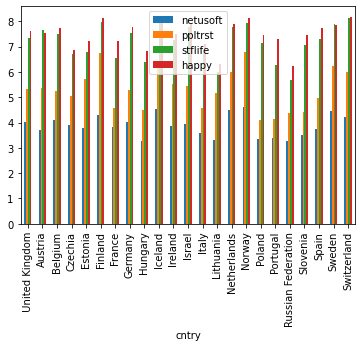

In [25]:
survey.groupby(["cntry"]).mean()[["netusoft", "ppltrst", "stflife", "happy"]].plot(kind="bar")

In [26]:
survey.corr()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
gndr,1.000000,-0.031490,-0.014348,0.024119,0.000733,-0.047495,-0.024883,-0.012635,-0.007556,-0.018253,-0.061293,0.000804,0.057426,-0.038159,0.025945,0.055477
nwspol,-0.031490,1.000000,0.021876,0.050674,-0.041172,-0.080920,-0.005136,-0.037150,-0.014009,-0.024786,-0.021521,-0.029792,0.068211,-0.001530,-0.007361,0.026520
netustm,-0.014348,0.021876,1.000000,-0.086828,0.126390,0.191073,-0.004497,0.001665,-0.011465,-0.018610,-0.011136,0.008845,-0.052080,-0.026176,0.005421,0.034109
agea,0.024119,0.050674,-0.086828,1.000000,-0.071128,-0.190345,-0.012531,-0.022702,0.002033,-0.012053,-0.020031,-0.037867,0.122451,0.023024,-0.029765,-0.026065
eduyrs,0.000733,-0.041172,0.126390,-0.071128,1.000000,0.418087,0.176427,0.134395,0.030683,0.003597,0.007185,0.125440,-0.229925,-0.087670,0.168975,0.089578
netusoft,-0.047495,-0.080920,0.191073,-0.190345,0.418087,1.000000,0.159248,0.195297,0.031112,0.052349,0.081046,0.192899,-0.377306,-0.072709,0.174715,0.070866
ppltrst,-0.024883,-0.005136,-0.004497,-0.012531,0.176427,0.159248,1.000000,0.260062,0.237502,0.225243,0.226185,0.225849,-0.173175,-0.001356,0.145208,0.002714
stflife,-0.012635,-0.037150,0.001665,-0.022702,0.134395,0.195297,0.260062,1.000000,0.265704,0.268141,0.293273,0.702668,-0.358422,-0.046141,0.151716,-0.013726
stfgov,-0.007556,-0.014009,-0.011465,0.002033,0.030683,0.031112,0.237502,0.265704,1.000000,0.380861,0.340275,0.206453,-0.106443,0.052656,0.071474,-0.049549
stfedu,-0.018253,-0.024786,-0.018610,-0.012053,0.003597,0.052349,0.225243,0.268141,0.380861,1.000000,0.473089,0.234644,-0.134528,0.017663,0.049079,-0.069696


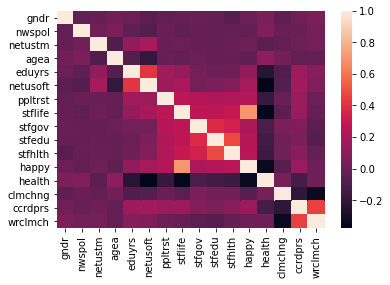

In [27]:
sns.heatmap(survey.corr())

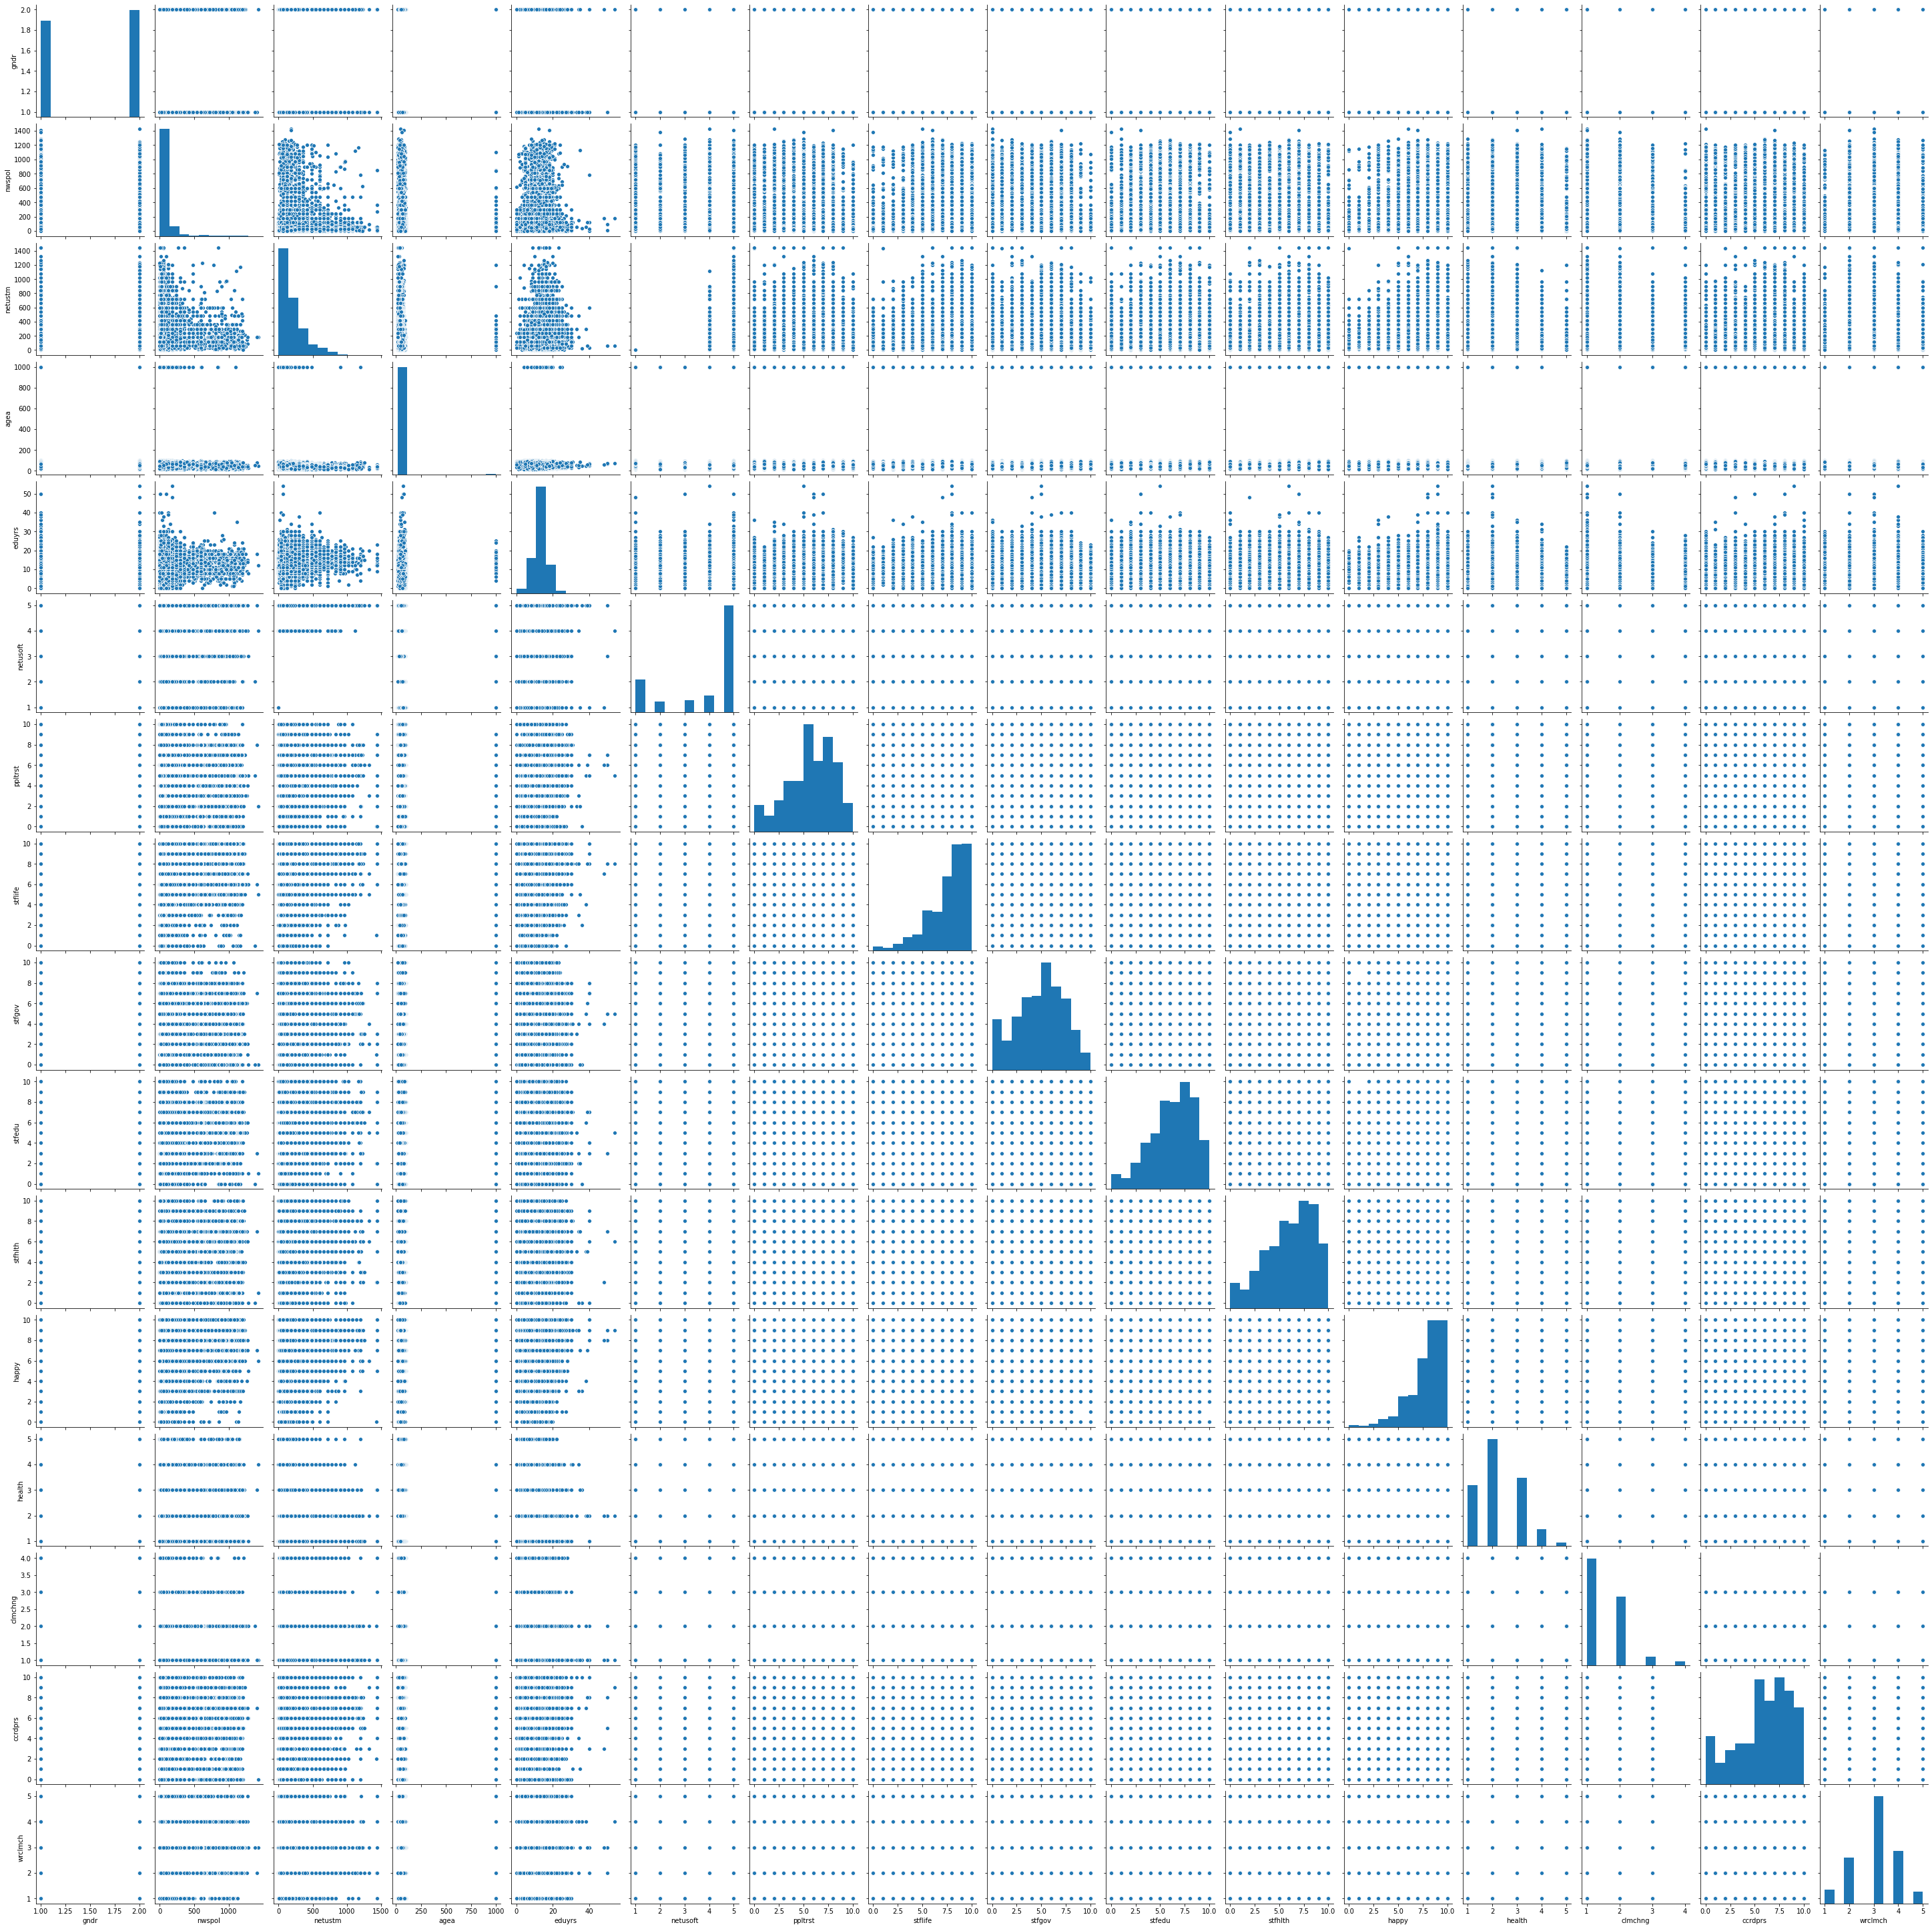

In [43]:
sns.pairplot(survey)

In [28]:
# Health vs Satisfaction in life analysis
# stflife - All things considered, how satisfied are you with your life as a whole nowadays? Please answer using this card, where 0 means extremely dissatisfied and 10 means extremely satisfied.
# health - How is your health in general? (1 - very good, 5 - very bad)

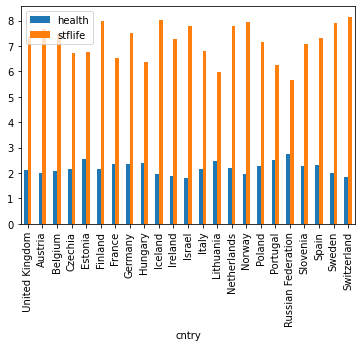

In [29]:
survey.groupby(["cntry"]).mean()[["health", "stflife"]].plot(kind="bar")

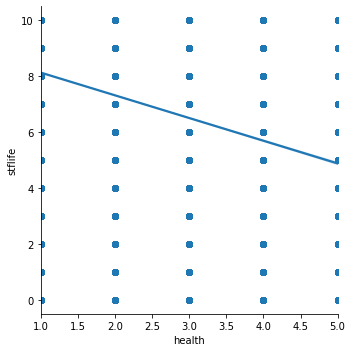

In [30]:
sns.lmplot(x="health", y="stflife", data=survey)

In [31]:
survey.groupby('cntry').mean().sort_values(by="health", ascending =True).head(10)[['health', 'stflife']]

,health,stflife
cntry,,
Israel,1.819357,7.794025
Switzerland,1.834098,8.149606
Ireland,1.871916,7.255087
Iceland,1.948513,8.025229
Norway,1.970874,7.937784
Austria,1.996018,7.660359
Sweden,1.999353,7.891051
Belgium,2.089468,7.481566
United Kingdom,2.112302,7.336229


In [32]:
# corr. coeff. -0.159082

health_model = smf.ols(formula="stflife ~ health", data = survey).fit()
print(health_model.params)
print(health_model.summary())

Intercept    8.940202
health      -0.811808
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                stflife   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     6507.
Date:                Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:54:05   Log-Likelihood:                -92053.
No. Observations:               44144   AIC:                         1.841e+05
Df Residuals:                   44142   BIC:                         1.841e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [33]:
# Happines vs Satisfaction in life analysis
# happy - How happy are you (0- Extremely unhappy, 10 Extremely happy)
# stflife - All things considered, how satisfied are you with your life as a whole nowadays? Please answer using this card, where 0 means extremely dissatisfied and 10 means extremely satisfied.

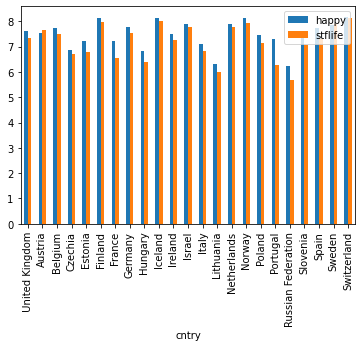

In [34]:
survey.groupby(["cntry"]).mean()[["happy", "stflife"]].plot(kind="bar")

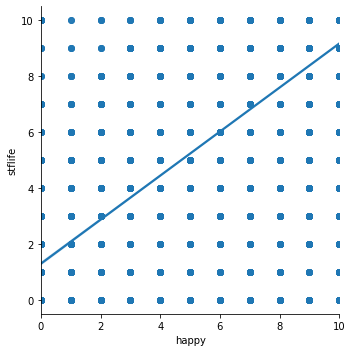

In [35]:
sns.lmplot(x="happy", y="stflife", data=survey)

In [36]:
# corr. coeff. 0.702668

health_model = smf.ols(formula="stflife ~ happy", data = survey).fit()
print(health_model.params)
print(health_model.summary())

Intercept    1.294903
happy        0.787589
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                stflife   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                 4.292e+04
Date:                Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:54:20   Log-Likelihood:                -79744.
No. Observations:               44005   AIC:                         1.595e+05
Df Residuals:                   44003   BIC:                         1.595e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [37]:
# Optimising analysis by selecting data from Lithuanian respondends

In [38]:
survey_LT = survey.query('cntry in "Lithuania"')

In [39]:
survey_LT.describe()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
count,2122.000000,2030.000000,1070.000000,2122.000000,2082.000000,2120.000000,2111.000000,2081.000000,2067.000000,1947.000000,2095.000000,2080.000000,2118.000000,2068.000000,1796.000000,1898.000000
mean,1.594251,82.325123,193.816822,57.520264,12.772815,3.327358,5.176694,5.983181,4.069666,5.157165,4.807160,6.307212,2.459868,1.714700,4.904788,2.874605
std,0.491152,83.615697,141.085018,86.588765,2.896546,1.679178,2.327977,2.138971,2.098952,2.162455,2.391494,2.108492,0.878034,0.824654,2.648458,0.910941
min,1.000000,0.000000,0.000000,15.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,30.000000,100.000000,36.000000,11.000000,1.000000,4.000000,5.000000,3.000000,4.000000,3.000000,5.000000,2.000000,1.000000,3.000000,2.000000
50%,2.000000,60.000000,150.000000,52.000000,13.000000,4.000000,5.000000,6.000000,4.000000,5.000000,5.000000,7.000000,2.000000,2.000000,5.000000,3.000000
75%,2.000000,120.000000,240.000000,66.000000,15.000000,5.000000,7.000000,8.000000,6.000000,7.000000,7.000000,8.000000,3.000000,2.000000,7.000000,3.000000
max,2.000000,780.000000,840.000000,999.000000,25.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,4.000000,10.000000,5.000000


In [40]:
survey_LT.corr()

,gndr,nwspol,netustm,agea,eduyrs,netusoft,ppltrst,stflife,stfgov,stfedu,stfhlth,happy,health,clmchng,ccrdprs,wrclmch
gndr,1.000000,-0.039229,0.010516,0.048734,0.033531,-0.030598,0.004249,-0.044940,-0.074578,-0.034675,-0.055057,-0.012378,0.094845,-0.052592,0.036469,0.069798
nwspol,-0.039229,1.000000,-0.078545,0.089831,-0.095065,-0.314863,-0.026221,-0.103948,0.079945,0.073018,0.003436,-0.089267,0.270863,0.002721,0.007148,0.038761
netustm,0.010516,-0.078545,1.000000,-0.065680,0.125413,0.217389,-0.052549,0.122837,-0.070474,-0.066581,-0.089579,0.126171,-0.060747,0.007284,0.056075,-0.012989
agea,0.048734,0.089831,-0.065680,1.000000,-0.031076,-0.151089,-0.005346,-0.076979,0.020148,0.004055,0.004728,-0.055546,0.148191,0.004766,-0.020203,0.024612
eduyrs,0.033531,-0.095065,0.125413,-0.031076,1.000000,0.379803,0.090977,0.146832,0.034136,-0.030440,0.027331,0.173351,-0.245329,-0.079477,0.089892,0.042065
netusoft,-0.030598,-0.314863,0.217389,-0.151089,0.379803,1.000000,0.151219,0.380236,0.118111,0.014180,0.132295,0.315057,-0.553929,-0.028377,0.058389,-0.084475
ppltrst,0.004249,-0.026221,-0.052549,-0.005346,0.090977,0.151219,1.000000,0.302587,0.322464,0.239185,0.303771,0.241899,-0.178830,-0.012388,0.082509,-0.015248
stflife,-0.044940,-0.103948,0.122837,-0.076979,0.146832,0.380236,0.302587,1.000000,0.385743,0.308977,0.372017,0.697514,-0.401485,-0.037225,0.148876,0.004324
stfgov,-0.074578,0.079945,-0.070474,0.020148,0.034136,0.118111,0.322464,0.385743,1.000000,0.493251,0.536535,0.321329,-0.122372,-0.036191,0.145697,0.023325
stfedu,-0.034675,0.073018,-0.066581,0.004055,-0.030440,0.014180,0.239185,0.308977,0.493251,1.000000,0.662039,0.325628,-0.103320,-0.077678,0.090596,-0.035202


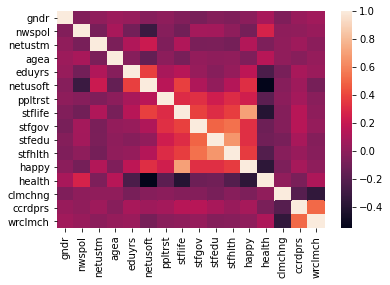

In [41]:
sns.heatmap(survey_LT.corr())

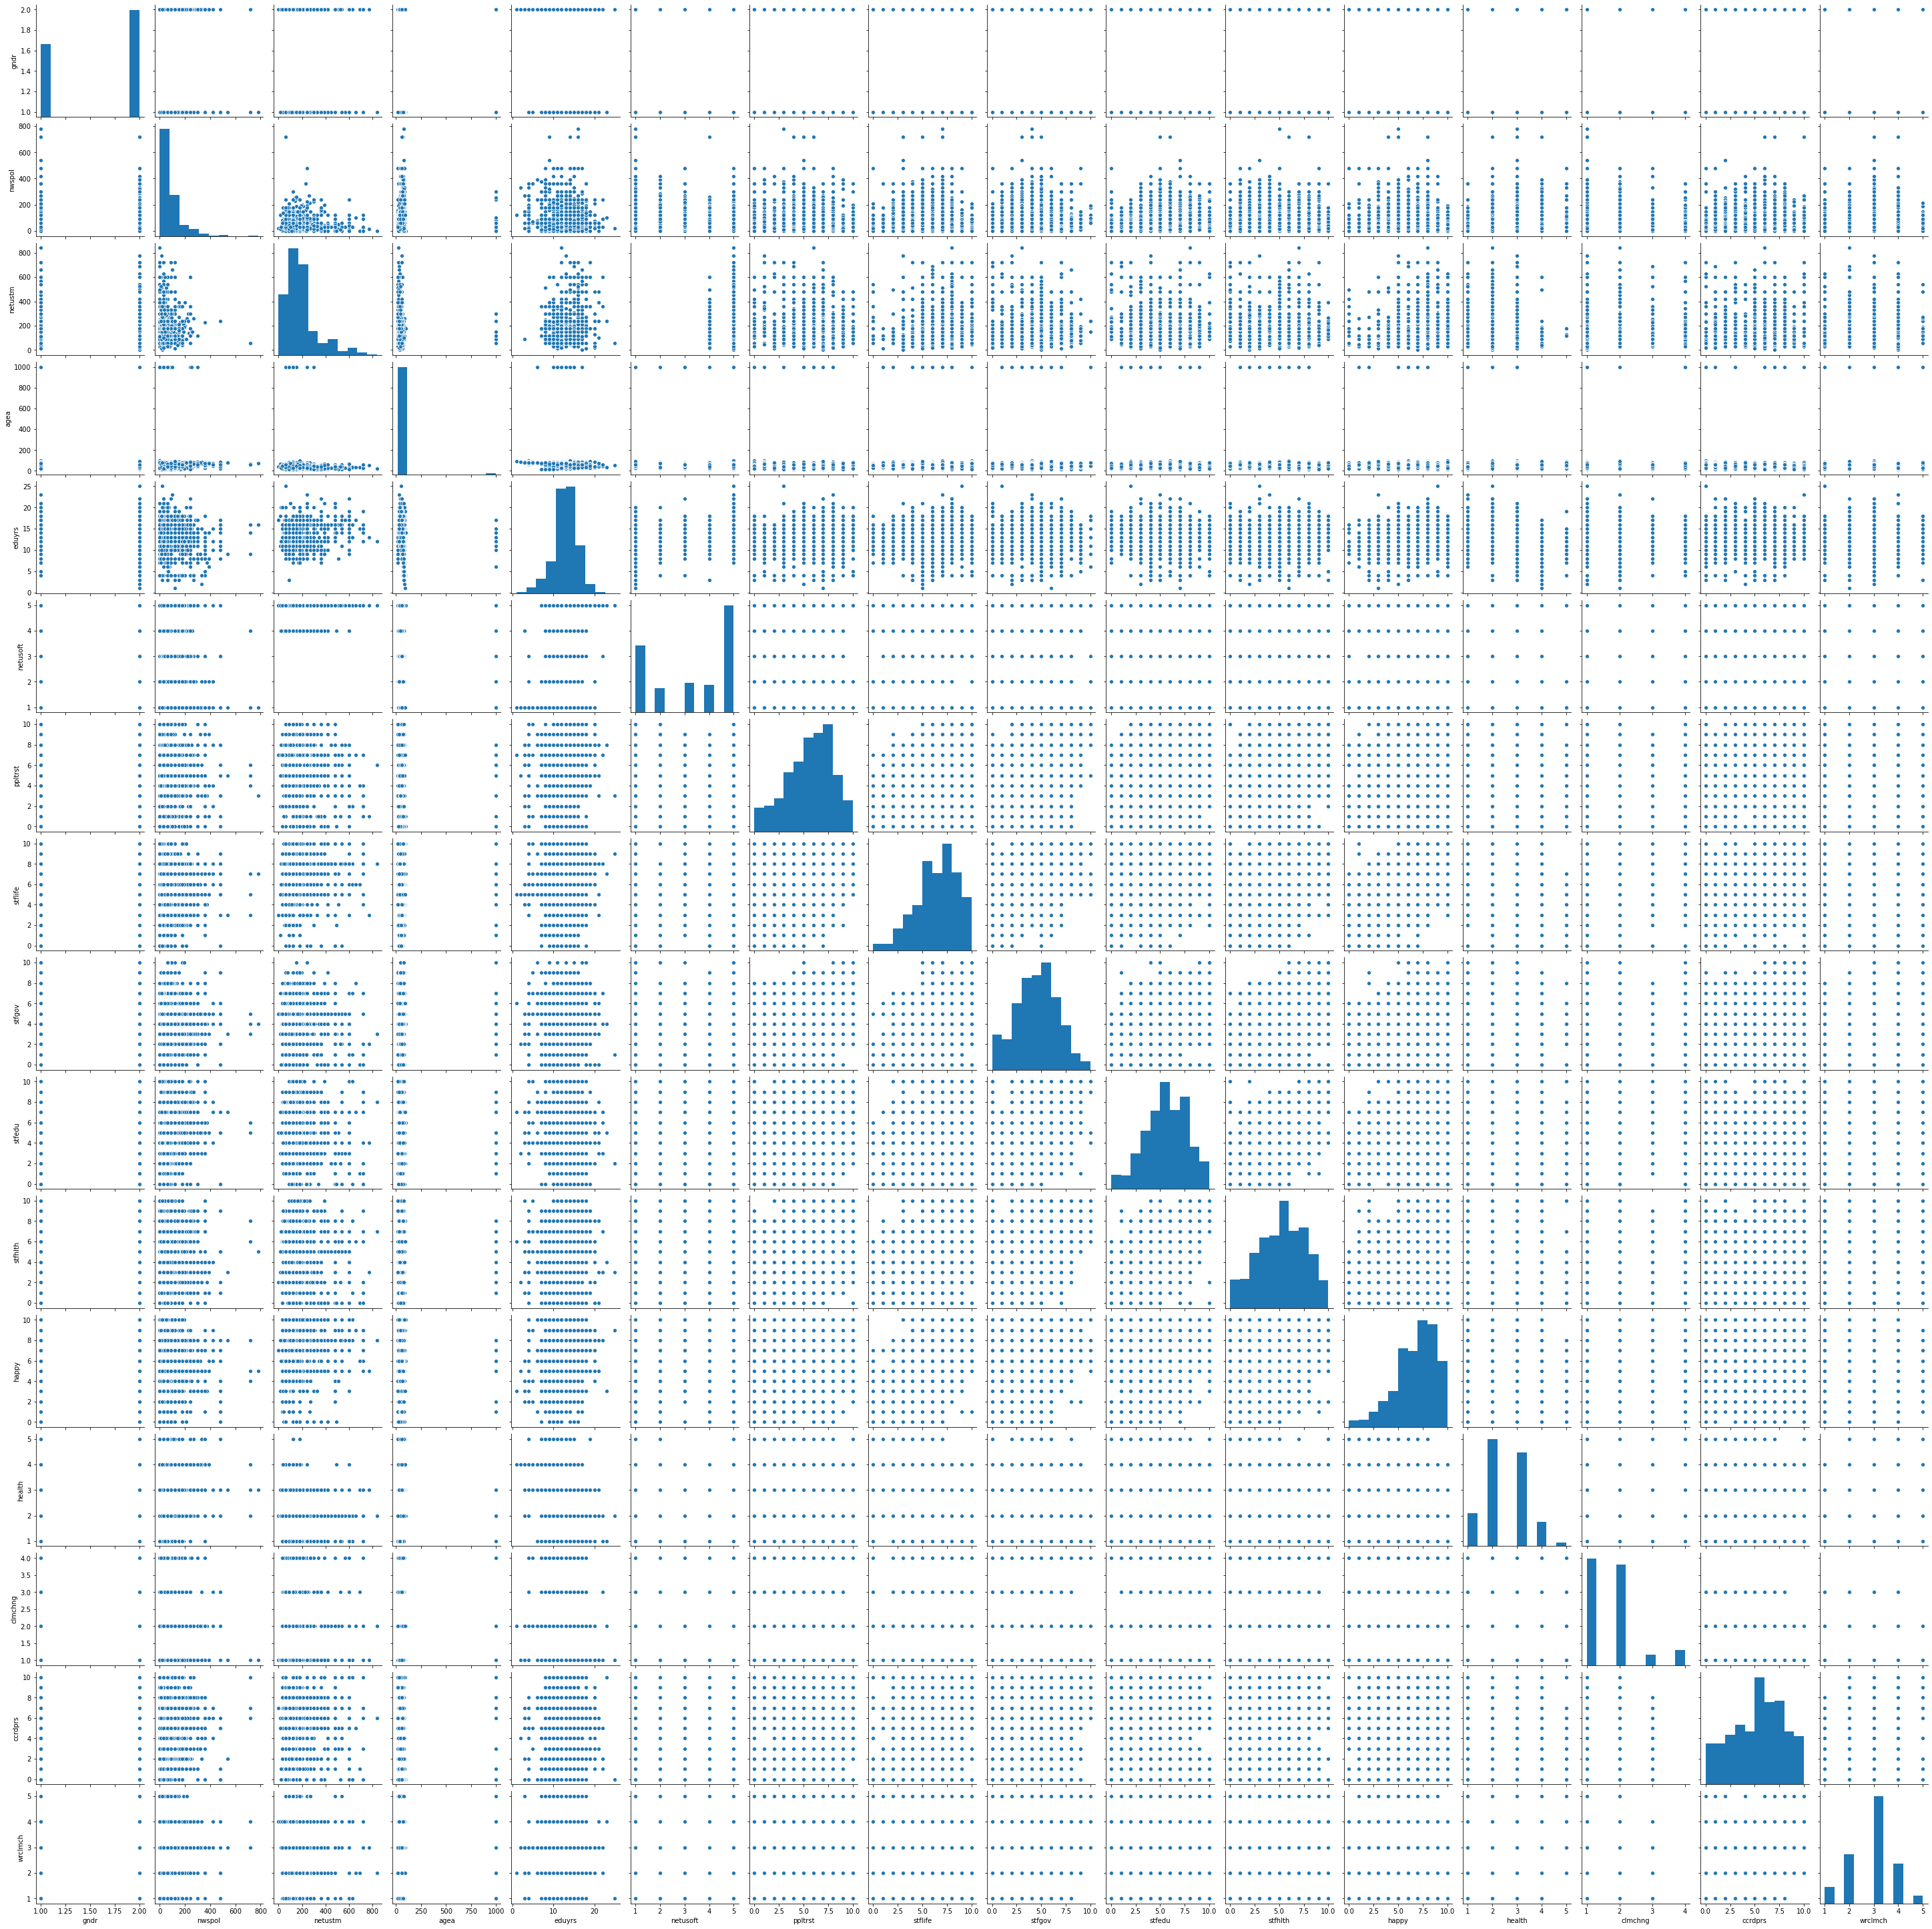

In [62]:
sns.pairplot(survey_LT)

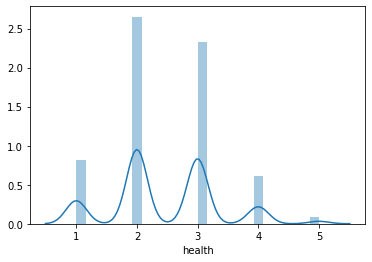

In [42]:
sns.distplot(survey_LT['health'])

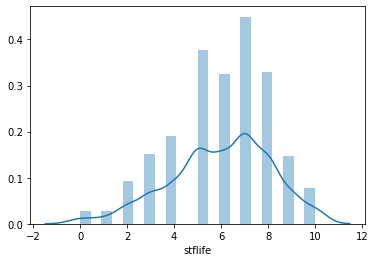

In [43]:
sns.distplot(survey_LT['stflife'])

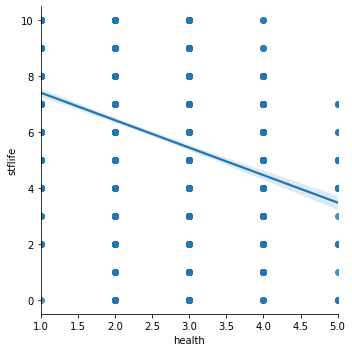

In [44]:
sns.lmplot(x="health", y="stflife", data=survey_LT)

In [45]:
# corr. -0.401485
LT_health_model = smf.ols(formula="stflife ~ health", data = survey_LT).fit()
print(LT_health_model.params)
print(LT_health_model.summary())

Intercept    8.391709
health      -0.982333
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                stflife   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     398.9
Date:                Mon, 09 Nov 2020   Prob (F-statistic):           2.52e-81
Time:                        17:54:49   Log-Likelihood:                -4346.3
No. Observations:                2078   AIC:                             8697.
Df Residuals:                    2076   BIC:                             8708.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

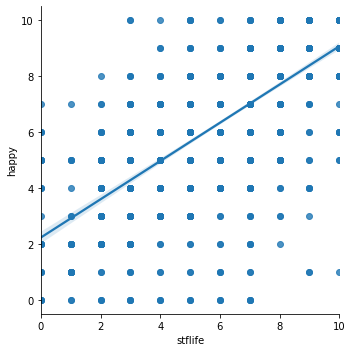

In [46]:
sns.lmplot(x="stflife", y="happy", data=survey_LT)

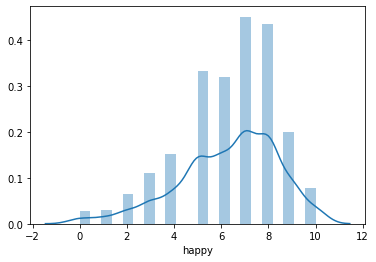

In [47]:
sns.distplot(survey_LT['happy'])

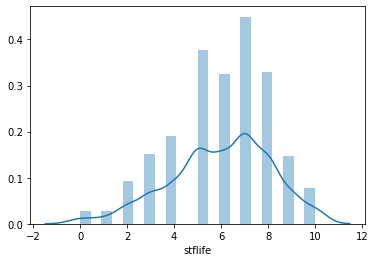

In [48]:
sns.distplot(survey_LT['stflife'])

In [49]:
# corr. 0.697514
LT_happiness_model = smf.ols(formula="happy ~ stflife", data = survey_LT).fit()
print(LT_happiness_model.params)
print(LT_happiness_model.summary())

Intercept    2.231574
stflife      0.684041
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     1935.
Date:                Mon, 09 Nov 2020   Prob (F-statistic):          6.95e-298
Time:                        17:55:04   Log-Likelihood:                -3734.6
No. Observations:                2044   AIC:                             7473.
Df Residuals:                    2042   BIC:                             7484.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

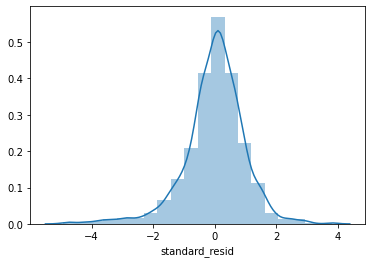

In [50]:
from sklearn.model_selection import train_test_split
x = survey_LT[['stflife']]
y = survey_LT['happy']
#Spliting data into two sets, for testing and training the model. 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)

train_set = x_train.copy()
train_set['happy'] = y_train

# Testing model:
est = smf.ols('happy ~ stflife', train_set).fit()

from statsmodels.stats.outliers_influence import OLSInfluence
std_res = OLSInfluence(est).summary_frame()

sns.distplot(std_res["standard_resid"], bins=20)

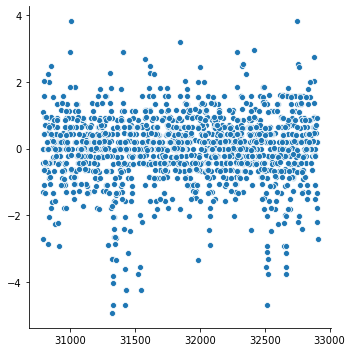

In [51]:
sns.relplot(data=std_res["standard_resid"])

In [52]:
std_res[np.abs(std_res['standard_resid']) > 3]

,dfb_Intercept,dfb_stflife,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
32523,-0.098543,0.075003,0.006171,-3.316206,0.001121,-0.111090,-3.326435,-0.111433
31003,0.155657,-0.131056,0.013023,3.831041,0.001771,0.161388,3.847236,0.162070
32747,0.155657,-0.131056,0.013023,3.831041,0.001771,0.161388,3.847236,0.162070
31982,0.009547,-0.040226,0.004247,-3.350034,0.000756,-0.092163,-3.360602,-0.092454
31323,0.121780,-0.174004,0.022404,-4.936049,0.001836,-0.211681,-4.971855,-0.213216
31422,0.013403,-0.056474,0.008315,-4.687513,0.000756,-0.128959,-4.718001,-0.129798
31329,0.013403,-0.056474,0.008315,-4.687513,0.000756,-0.128959,-4.718001,-0.129798
32660,-0.071216,0.041818,0.005234,-3.772864,0.000735,-0.102315,-3.788294,-0.102734
31327,-0.098543,0.075003,0.006171,-3.316206,0.001121,-0.111090,-3.326435,-0.111433
31324,-0.098543,0.075003,0.006171,-3.316206,0.001121,-0.111090,-3.326435,-0.111433


In [53]:
pred = est.get_prediction(x_test)
pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,7.693309,0.051031,7.593215,7.793403,4.757479,10.629140
1,5.641818,0.040552,5.562278,5.721359,2.706616,8.577020
2,7.009479,0.041139,6.928788,7.090170,4.074246,9.944712
3,3.590327,0.077536,3.438246,3.742409,0.652264,6.528390
4,5.641818,0.040552,5.562278,5.721359,2.706616,8.577020
...,...,...,...,...,...,...
413,5.641818,0.040552,5.562278,5.721359,2.706616,8.577020
414,7.009479,0.041139,6.928788,7.090170,4.074246,9.944712
415,4.957988,0.050084,4.859752,5.056224,2.022220,7.893756
416,7.009479,0.041139,6.928788,7.090170,4.074246,9.944712
